In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Callable
import pandas as pd
import math
import numpy as np
from tqdm import tqdm

In [3]:
params = {
    "steps": 10000
}

In [4]:
def euler(f: Callable, condition: tuple, final_x: float, steps=None, h=None):
    if not steps is None:
        h = (final_x - condition[0]) / steps
    elif h is None:
        h = (final_x - condition[0]) / params["steps"]
    cur_x = condition[0]
    cur_y = condition[1]
    while cur_x < final_x-h:
        cur_y = cur_y + h*f(cur_x,cur_y)
        cur_x +=h
    return cur_y

def euler_retun_all(f: Callable, condition: tuple, final_x: float, steps=None, h=None):
    if not steps is None:
        h = (final_x - condition[0]) / steps
    elif h is None:
        h = (final_x - condition[0]) / params["steps"]
    out_x, out_y = [],[]
    out_x.append(condition[0])
    out_y.append(condition[1])
    while out_x[-1] < final_x:
        out_y.append(out_y[-1] + h*f(out_x[-1],out_y[-1]))
        out_x.append(out_x[-1]+h)
    return pd.DataFrame({"x":out_x,"y":out_y})

def runge_kutta_4(f: Callable, condition: tuple, final_x: float, steps=None, h=None):
    if not steps is None:
        h = (final_x - condition[0]) / steps
    elif h is None:
        h = (final_x - condition[0]) / params["steps"]
    cur_x = condition[0]
    cur_y = condition[1]
    sixth = 1/6
    while cur_x < final_x-h:
        k1 = f(cur_x, cur_y)
        k2 = f(cur_x + h*0.5, cur_y + h*0.5*k1)
        k3 = f(cur_x + h*0.5, cur_y + h*0.5*k2)
        k4 = f(cur_x + h, cur_y + h*k3)
        cur_y = cur_y + h*sixth*( k1 + 2*k2 + 2*k3 + k4 )
        cur_x +=h
    return cur_y

def runge_kutta_4_all(f: Callable, condition: tuple, final_x: float, steps=None, h=None):
    if not steps is None:
        h = (final_x - condition[0]) / steps
    elif h is None:
        h = (final_x - condition[0]) / params["steps"]
    out_x, out_y = [],[]
    out_x.append(condition[0])
    out_y.append(condition[1])
    sixth = 1/6
    while out_x[-1] < final_x:
        k1 = f(out_x[-1], out_y[-1])
        k2 = f(out_x[-1] + h*0.5, out_y[-1] + h*0.5*k1)
        k3 = f(out_x[-1] + h*0.5, out_y[-1] + h*0.5*k2)
        k4 = f(out_x[-1] + h, out_y[-1] + h*k3)
        out_y.append(out_y[-1] + h*sixth*( k1 + 2*k2 + 2*k3 + k4 ))
        out_x.append(out_x[-1]+h)
    return pd.DataFrame({"x":out_x,"y":out_y})

In [6]:
problem_1 = euler_retun_all(lambda x,y: 2*x - 3*y + 1, (1,5), 1.2, h=0.1)
print(problem_1)
problem_2 = euler_retun_all(lambda x,y: x + y**2, (0,0), 0.2, h=0.1)
print(problem_2)
problem_3 = euler_retun_all(lambda x,y: 2*x - 3*y + 1, (1,5), 1.2, h=0.05)
print(problem_3)
problem_4 = euler_retun_all(lambda x,y: x + y**2, (0,0), 0.2, h=0.05)
print(problem_4)

     x     y
0  1.0  5.00
1  1.1  3.80
2  1.2  2.98
     x     y
0  0.0  0.00
1  0.1  0.00
2  0.2  0.01
      x         y
0  1.00  5.000000
1  1.05  4.400000
2  1.10  3.895000
3  1.15  3.470750
4  1.20  3.115138
      x         y
0  0.00  0.000000
1  0.05  0.000000
2  0.10  0.002500
3  0.15  0.007500
4  0.20  0.015003


In [72]:
y = lambda x: math.exp(x)
y_prime = lambda x,y: y
condition = (0,1)
end_x = 5
steps = 100
df = pd.DataFrame(columns=["x","truth","runge_kutta","euler"])
x_values = np.linspace(condition[0],end_x,steps)
df["x"] = x_values
df["truth"] = np.apply_along_axis(lambda arr: [y(x) for x in arr],0,x_values)
df["runge_kutta"] = runge_kutta_4_all(y_prime, condition, end_x, steps = steps)["y"]
df["euler"] = euler_retun_all(y_prime, condition, end_x, steps = steps)["y"]

In [73]:
new_df = df.drop("x",axis=1).stack().reset_index().drop("level_0",axis=1)
new_df.rename(columns={"level_1":"type",0:"y"},inplace=True)
new_df["x"] = np.repeat(df["x"].to_numpy(),3)
new_df.head()

,type,y,x
0,truth,1.000000,0.000000
1,runge_kutta,1.000000,0.000000
2,euler,1.000000,0.000000
3,truth,1.051802,0.050505
4,runge_kutta,1.051271,0.050505


In [108]:
def get_absolute_errors_vary_steps(y,y_prime,condition,end_x,steps_arr):
    y_truth = y(end_x)
    pre_df_raw = {"runge":[],"euler":[],"truth":[y_truth]*len(steps_arr),"steps":steps_arr}
    for steps in tqdm(steps_arr):
        pre_df_raw["runge"].append(runge_kutta_4(y_prime, condition, end_x, steps = steps))
        pre_df_raw["euler"].append(euler(y_prime, condition, end_x, steps = steps))
    df_raw = pd.DataFrame(pre_df_raw)
    df_out = pd.DataFrame(columns = ["runge_error","euler_error","steps"])
    df_out["steps"] = df_raw["steps"]
    df_out["runge_error"] = (df_raw["truth"] - df_raw["runge"]) / df_raw["truth"]
    df_out["euler_error"] = (df_raw["truth"] - df_raw["euler"]) / df_raw["truth"]
    return df_out
    

df_errors = get_absolute_errors_vary_steps(y,y_prime,condition,end_x,np.geomspace(1,10000,num=5))
df_errors.head()
df_use_error = df_errors.drop("steps",axis=1).stack().reset_index().drop("level_0",axis=1).rename(columns={"level_1":"type",0:"error"})
df_use_error["steps"] = np.repeat(df_errors["steps"].to_numpy(),2)
df_use_error.head()

100%|██████████| 5/5 [00:00<00:00, 150.67it/s]


,type,error,steps
0,runge_error,9.932621e-01,1.0
1,euler_error,9.932621e-01,1.0
2,runge_error,3.944082e-01,10.0
3,euler_error,7.409707e-01,10.0
4,runge_error,2.497951e-07,100.0


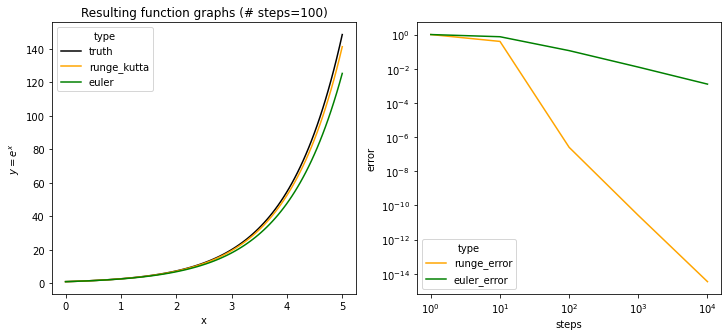

In [120]:
palette = {
    "truth": "black",
    "runge_kutta": "orange",
    "runge_error": "orange",
    "euler": "green",
    "euler_error": "green"
}
fig,axes = plt.subplots(ncols=2,figsize=(12,5))
sns.lineplot(x="x",y="y",hue="type",data=new_df,ax=axes[0],palette=palette)
sns.lineplot(x="steps",y="error",hue="type",data=df_use_error,ax=axes[1],palette=palette)
axes[0].set_title(f"Resulting function graphs (# steps={steps})")
axes[0].set_ylabel("$y=e^x$")
axes[1].set(xscale="log",yscale="log")
axes[1].minorticks_off()
axes[1].set_title("")
plt.savefig("numerical_comparison.png",dpi=600,bbox_inches="tight")